In [186]:

import seaborn as sns
import pyprind

# basic packages
import pandas as pd
import os
import numpy as np
import re # python regular expressions
import string # for efficient operations with strings
import matplotlib.pyplot as plt
%matplotlib inline

# For creating dictionaries that you can fill in a loop
from collections import defaultdict

# NLTK: A basic, popular NLP package. Find many examples of applications at https://www.nltk.org/book/
# Install guide: https://www.nltk.org/install.html
import nltk
nltk.download('punkt') # you will probably need to do this
nltk.download('wordnet') # and this
nltk.download('stopwords') # aand this

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vader Lexicon for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Lexicons for sentiment analysis
from vaderSentiment import vaderSentiment
from afinn import Afinn

# to display images in notebook
from IPython.display import Image

from pandas.core.common import flatten
from collections import Counter

[nltk_data] Downloading package punkt to /Users/mieharder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mieharder/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mieharder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [187]:
#read dataframes
professor_df=pd.read_csv('df_final.csv')
comment_df=pd.read_csv('df_comments_final.csv')
comment_df['Dates']=pd.to_datetime(comment_df.Dates, format='%Y-%m-%d')
comment_df['Month']=comment_df['Dates'].dt.month

comment_df['Month'].value_counts()
comment_df

,Unnamed: 0,Comments,Quality,Difficulty,Dates,TeacherID,SchoolID,status,Month
0,0,"Professor Acres is incredible--friendly, knowl...",5.0,4.0,2017-05-02,336888,780,top,5.0
1,1,He is an amazing professor- I definitely recom...,5.0,3.0,2017-04-28,336888,780,top,4.0
2,2,Great!,3.0,3.0,2012-03-23,336888,780,top,3.0
3,3,Awesome,5.0,1.0,2011-02-01,336888,780,top,2.0
4,4,Al is an absolutely great professor. His semin...,5.0,4.0,2007-10-21,336888,780,top,10.0
...,...,...,...,...,...,...,...,...,...
81712,81712,Difficult to understand and not very helpful. ...,1.5,3.0,2009-12-23,608528,4171,bottom,12.0
81713,81713,MUY MAL!! This teacher is unorganized and scat...,1.0,1.0,2005-12-22,608528,4171,bottom,12.0
81714,81714,very sweet disposition -- very willing to help...,5.0,1.0,2005-12-20,608528,4171,bottom,12.0
81715,81715,"This professor is very helpful, wants her stud...",5.0,1.0,2005-09-06,608528,4171,bottom,9.0


In [225]:
def preprocess(text):
    low_text= text.lower()
    low_text = low_text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(low_text)
    porter = nltk.WordNetLemmatizer()
    lemmatizer=[porter.lemmatize(t) for t in tokens]
    stop_words_list = stoppelop
    sent_sw_removed = [i for i in lemmatizer if i not in stop_words_list]
    lemmas=[i for i in sent_sw_removed if i!='br']
    return lemmas # return a list of stems/lemmas

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


<AxesSubplot:xlabel='Month', ylabel='Density'>

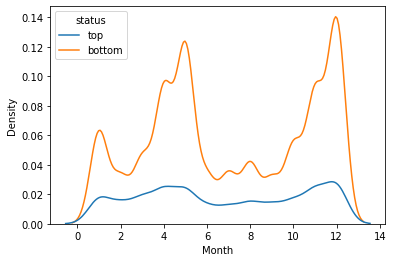

In [189]:
print(type(comment_df.Dates[0]))
plt.figure()
#plt.hist(comment_df.Quality)
#plt.hist(comment_df.Difficulty)
#sns.kdeplot(data=comment_df, x='Month') #antal reviews pr måned
sns.kdeplot(data=comment_df, x='Month', hue='status')

In [190]:
comment_df[comment_df['Comments'].isna()]

,Unnamed: 0,Comments,Quality,Difficulty,Dates,TeacherID,SchoolID,status,Month
15,15,NaN,1.0,3.0,2010-03-28,1348710,780,top,3.0
105,105,NaN,5.0,3.0,2010-06-29,650499,780,top,6.0
129,129,NaN,5.0,4.0,2010-02-25,1394628,780,top,2.0
240,240,NaN,5.0,4.0,2010-07-14,1433584,780,top,7.0
310,310,NaN,4.0,3.0,2010-12-03,812251,780,top,12.0
...,...,...,...,...,...,...,...,...,...
80232,80232,NaN,5.0,2.0,2010-04-28,1156290,4171,bottom,4.0
80257,80257,NaN,4.5,4.0,2010-03-28,1366059,4171,bottom,3.0
80481,80481,NaN,3.5,1.0,2010-07-18,1277921,4171,bottom,7.0
80484,80484,NaN,3.5,1.0,2010-07-18,1369422,4171,bottom,7.0


In [226]:
comment_df=comment_df[comment_df['Comments']!='No Comments'].dropna()
comment_df['Clean_comment']=comment_df.apply(lambda row: preprocess(row.Comments), axis = 1)


In [219]:
def join_stop_list(professor_df):
    specialized_stop_list=list(professor_df.institution_name)+list(professor_df.tDept)+list(professor_df.tFname)+list(professor_df.tMiddlename)+list(professor_df.tLname)
    hej=set(specialized_stop_list)
    hallo=[str(i) for i in hej]
    stop_string=' '.join(hallo)
    proc_stop_string=preprocess(stop_string)
    return proc_stop_string+nltk.corpus.stopwords.words("english")

stoplist=join_stop_list(professor_df)
with open('STOPlist.txt', 'w') as f:
    for item in stoplist:
        f.write("%s\n" % item)



In [232]:
with open('STOPlist.txt') as f:
    stoppelop = f.read().splitlines()

In [215]:
comment_df['Comment_length']=comment_df.apply(lambda row: len(row.Comments), axis = 1)


,Unnamed: 0,Comments,Quality,Difficulty,Dates,TeacherID,SchoolID,status,Month,Clean_comment,Comment_length
0,0,"Professor Acres is incredible--friendly, knowl...",5.0,4.0,2017-05-02,336888,780,top,5.0,"[professor, acre, incrediblefriendly, knowledg...",343
1,1,He is an amazing professor- I definitely recom...,5.0,3.0,2017-04-28,336888,780,top,4.0,"[amazing, professor, definitely, recommend]",54
2,2,Great!,3.0,3.0,2012-03-23,336888,780,top,3.0,[great],6
3,3,Awesome,5.0,1.0,2011-02-01,336888,780,top,2.0,[awesome],7
4,4,Al is an absolutely great professor. His semin...,5.0,4.0,2007-10-21,336888,780,top,10.0,"[al, absolutely, great, professor, seminar, wa...",339
...,...,...,...,...,...,...,...,...,...,...,...
81712,81712,Difficult to understand and not very helpful. ...,1.5,3.0,2009-12-23,608528,4171,bottom,12.0,"[difficult, understand, helpful, course, suppo...",350
81713,81713,MUY MAL!! This teacher is unorganized and scat...,1.0,1.0,2005-12-22,608528,4171,bottom,12.0,"[muy, mal, teacher, unorganized, scatter, brai...",236
81714,81714,very sweet disposition -- very willing to help...,5.0,1.0,2005-12-20,608528,4171,bottom,12.0,"[sweet, disposition, willing, help, stufdents,...",230
81715,81715,"This professor is very helpful, wants her stud...",5.0,1.0,2005-09-06,608528,4171,bottom,9.0,"[professor, helpful, want, student, well, retu...",284


In [231]:
top=17512
bottom=59360
all=top+bottom
bottom/all

0.7721927359766885

In [227]:
top_uni=comment_df[comment_df['status']=='top']
bottom_uni=comment_df[comment_df['status']=='bottom']
sub_top=list(flatten(list(top_uni.Clean_comment)))
sub_bottom=list(flatten(list(bottom_uni.Clean_comment)))


sub_top_high=top_uni[top_uni.Quality>4]
sub_top_low=top_uni[top_uni.Quality<2]
sub_bottom_high=bottom_uni[bottom_uni.Quality>4]
sub_bottom_low=bottom_uni[bottom_uni.Quality<2]

hej=list(flatten(list(sub_top_high.Clean_comment)))



In [182]:
top_count=Counter(sub_top).most_common(10)
bottom_count=Counter(sub_bottom).most_common(10)

Counter(list(flatten(list(sub_top_high.Clean_comment)))).most_common(10) #top low #top high
#Counter(list(flatten(list(sub_top_low.Clean_comment)))).most_common(10) #top low
Counter(list(flatten(list(sub_bottom_high.Clean_comment)))).most_common(10) #bottom high
#Counter(list(flatten(list(sub_bottom_low.Clean_comment)))).most_common(10) #bottom low


[('class', 26287),
 ('professor', 10812),
 ('wa', 8857),
 ('great', 7273),
 ('take', 6976),
 ('easy', 6601),
 ('teacher', 6534),
 ('student', 6191),
 ('test', 5795),
 ('really', 5623)]

In [167]:
df = professor_df[professor_df.tNumRatings != 0]
mathdf=df[df.tDept == 'Mathematics']
englishdf=df[df.tDept == 'English']
psychdf=df[df.tDept == 'Psychology']
enginedf=df[df.tDept == 'Engineering']
testdf=pd.concat([mathdf, englishdf, enginedf, psychdf])


In [224]:
with pd.option_context('display.max_colwidth', None):
  display(comment_df)


,Unnamed: 0,Comments,Quality,Difficulty,Dates,TeacherID,SchoolID,status,Month,Clean_comment,Comment_length
0,0,"Professor Acres is incredible--friendly, knowledgeable, & passionate. He knows the material well and shares his enthusiasm for it with the class. He kept lectures upbeat/interesting, and I really learned from him. Heavy memorization of pieces, but he leaves room for creativity in essays. I only wish I had been able to get to know him better!",5.0,4.0,2017-05-02,336888,780,top,5.0,"[professor, acre, incrediblefriendly, knowledgeable, passionate, know, material, well, share, enthusiasm, class, kept, lecture, upbeatinteresting, really, learned, heavy, memorization, piece, leaf, room, creativity, essay, wish, able, get, know, better]",343
1,1,He is an amazing professor- I definitely recommend him,5.0,3.0,2017-04-28,336888,780,top,4.0,"[amazing, professor, definitely, recommend]",54
2,2,Great!,3.0,3.0,2012-03-23,336888,780,top,3.0,[great],6
3,3,Awesome,5.0,1.0,2011-02-01,336888,780,top,2.0,[awesome],7
4,4,"Al is an absolutely great professor. His seminar was the most engaging I had at Princeton--and I studied with some of the top people. He is meticulously well-prepared, rigorous, and he really cares about the material he teaches. He also cares about his students. If you have a chance to study with this man, don't miss it. A great teacher!",5.0,4.0,2007-10-21,336888,780,top,10.0,"[al, absolutely, great, professor, seminar, wa, engaging, princetonand, studied, top, people, meticulously, wellprepared, rigorous, really, care, material, teach, also, care, student, chance, study, man, dont, miss, great, teacher]",339
...,...,...,...,...,...,...,...,...,...,...,...
81712,81712,"Difficult to understand and not very helpful. Course is supposed to be for those students with little to no Spanish background. She fully immerses us from day 1 and mostly taught with little to no English translations. She is not consistent in what she tells you to study for and what she actually tests over. Overall, poor teacher and waste of time!",1.5,3.0,2009-12-23,608528,4171,bottom,12.0,"[difficult, understand, helpful, course, supposed, student, little, spanish, background, fully, immerses, u, day, 1, mostly, taught, little, english, translation, consistent, tell, study, actually, test, overall, poor, teacher, waste, time]",350
81713,81713,"MUY MAL!! This teacher is unorganized and scatter brained and I learned nothing more that what I knew going in. If you want to learn spanish, take utley.If you want an easy grade, take Zuazu. Very nice lady but not an effective teacher.",1.0,1.0,2005-12-22,608528,4171,bottom,12.0,"[muy, mal, teacher, unorganized, scatter, brained, learned, nothing, knew, going, want, learn, spanish, take, utleyif, want, easy, grade, take, zuazu, nice, lady, effective, teacher]",236
81714,81714,very sweet disposition -- very willing to help stufdents out. a little disorganized adn i feel as though i could have been taught more than what i was. her tests were easy and what work she did make you turn in was also very easy.,5.0,1.0,2005-12-20,608528,4171,bottom,12.0,"[sweet, disposition, willing, help, stufdents, little, disorganized, adn, feel, though, could, taught, wa, test, easy, work, make, turn, wa, also, easy]",230
81715,81715,"This professor is very helpful, wants her students to do well, returned assignments in a timely manner, gave good test reviews, and provided a variety of ways to practice the French language, including in class discussion, so that you're more likely to learn. I highly recommend her.",5.0,1.0,2005-09-06,608528,4171,bottom,9.0,"[professor, helpful, want, student, well, returned, assignment, timely, manner, gave, good, test, review, provided, variety, way, practice, french, language, including, class, discussion, youre, likely, learn, highly, recommend]",284


In [164]:
del comment_df['Clean_comment']

<AxesSubplot:xlabel='status', ylabel='Comment_length'>

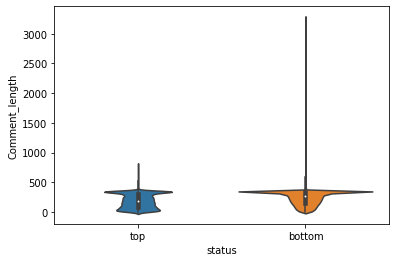

In [223]:
#df.tDept.value_counts()
#sns.kdeplot(data=comment_df, x='Quality', hue='Difficulty')
sns.violinplot(x='tDept', y='Comment_length', data=comment_df)
#comment_df